###### Saving topo files as png/jpg files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# The functions

In [2]:
def truncate(z):
    zt = np.trunc( (z-z.min())/(z.max()-z.min())*255. )
    err = zt*(z.max()-z.min())/255.+z.min()-z
    errrel = np.where( 1-np.isclose(z,0.0), np.abs(err)/z, 0.0)    
    return zt,err,errrel

def compare(x,y,z,zt,err,errrel):    
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.pcolormesh(zt)
    plt.colorbar()
    plt.title('truncated topo/bathy')
    plt.axis('off')

    plt.subplot(132)
    plt.pcolormesh(x,y,err,cmap=plt.cm.hot)
    plt.colorbar()
    plt.title('Absolute error \n(quantification)')
    plt.axis('off')

    plt.subplot(133)
    plt.pcolormesh(x,y,np.log(errrel),vmin=-10.,vmax=10.)
    plt.colorbar()
    plt.title('log of relative error \n(quantification)')
    plt.axis('off')

    plt.tight_layout()    

def saveImage(x,y,z,rootName):
    from scipy.misc import toimage
    im = toimage(np.flipud(z))
    print im
    im.save(rootName+'.jpg')
    f = open(rootName+'.txt','w')
    f.write('ny   :%i\n'%z.shape[0])
    f.write('nx   :%i\n'%z.shape[1])
    f.write('xmin :%.3f\n'%x.min())
    f.write('xmax :%.3f\n'%x.max())
    f.write('ymin :%.3f\n'%y.min())
    f.write('ymax :%.3f\n'%y.max())
    f.write('zmin :%.3f\n'%z.min())
    f.write('zmax :%.3f\n'%z.max())
    f.close()      

# Cartesian grid

It shows only a part of Chile

In [3]:
h = loadmat('MorenoCS_h.mat')
z = h['zh'][0,0]
x = h['xh'][0,0][0,:]
y = h['yh'][0,0][0,:]

In [4]:
zt,err,errrel = truncate(z)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in log
/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


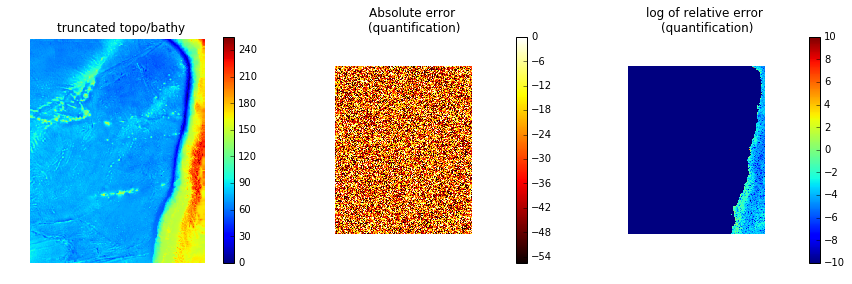

In [5]:
compare(x,y,z,zt,err,errrel)

In [6]:
saveImage(x,y,z,'bati1')
!cp bati1.jpg ../web/img/.

<PIL.Image.Image image mode=L size=432x594 at 0x7F87EC4C43D0>


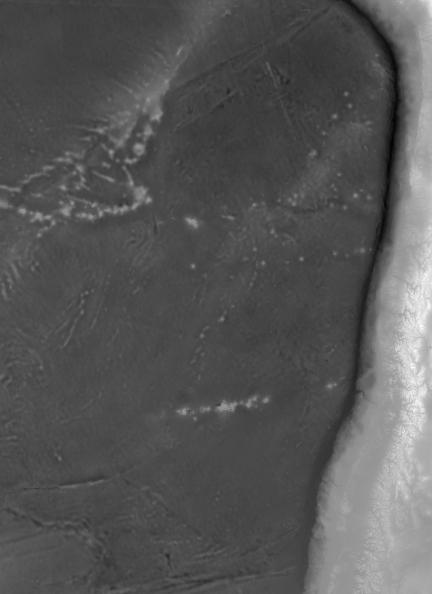

In [7]:
from IPython.display import Image
Image('bati1.jpg')

In [8]:
!cp bati1.txt ../web/img/.
!cat bati1.txt

ny   :594
nx   :432
xmin :-836516.000
xmax :1048678.000
ymin :5451636.000
ymax :8045418.000
zmin :-8104.293
zmax :6051.971


## Lat-lon grid
From geoclaw data

In [9]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
import clawpack.visclaw.colormaps as colormaps
topo_fname = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname,
        verbose=True)

data = np.loadtxt('etopo10min120W60W60S0S.asc',skiprows=6)
topo2 = topotools.Topography(topo_fname, topo_type=2)
# topo2 = topotools.Topography(topo_fname, topo_type=2)

Skipping http://www.geoclaw.org/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: ./etopo10min120W60W60S0S.asc


Truncate it into 32 bits numbers

In [10]:
topo2.Z = np.fliplr(np.reshape(topo2.Z,topo2.X.shape))

In [11]:
zt2,err2,errrel2 = truncate(topo2.Z)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in log


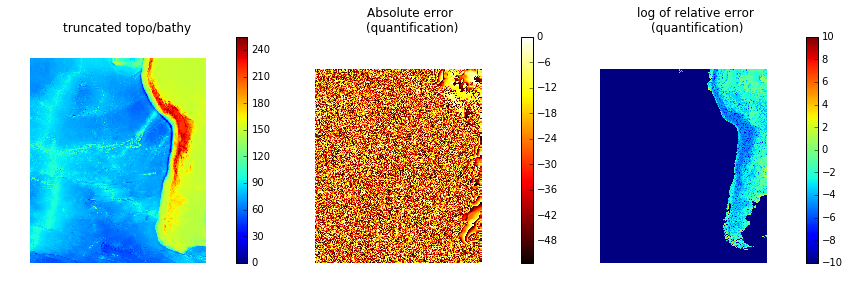

In [12]:
compare(topo2.X,topo2.Y, topo2.Z, zt2,err2,errrel2)

In [15]:
saveImage(topo2.X,topo2.Y,topo2.Z, 'batiLatLon')
!cp batiLatLon.jpg ../web/img/.

<PIL.Image.Image image mode=L size=361x361 at 0x7F87EC91B050>


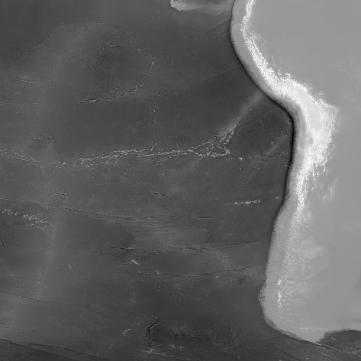

In [16]:
Image('batiLatLon.jpg')

In [17]:
!cp batiLatLon.txt ../web/img/.
!cat batiLatLon.txt

ny   :361
nx   :361
xmin :-120.000
xmax :-60.000
ymin :-60.000
ymax :0.000
zmin :-7939.000
zmax :5614.000


## Save a map

In [18]:
from scipy.misc import toimage
mean_lat = 0.5 * (topo2.Y.min()+topo2.Y.max())

topo_extent = (np.min(topo2.Z), np.max(topo2.Z))

# Create color map - assume shore is at z = 0.0
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

# sea_cmap = plt.get_cmap('Blues')
sea_cmap = colormaps.make_colormap({ 0.0: [0.0, 0.0, 0.1],
                                     1.0: [0.4,0.4,0.6]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                         data_limits=topo_extent,
                                         data_break=0.0)

In [19]:
Map = z
im = toimage(cmap(norm(np.flipud(topo2.Z))))
im.save('batiLatLonMap.jpg')
!cp batiLatLonMap.jpg ../web/img/.

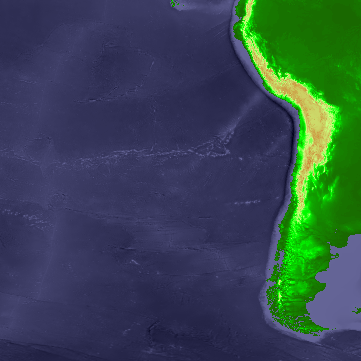

In [20]:
im

## Save a bump map

In [21]:
bumpMap = np.where(topo2.Z<0,0.0,topo2.Z)
im = toimage(np.flipud(bumpMap))
im.save('batiLatLonBumpMap.jpg')
!cp batiLatLonBumpMap.jpg ../web/img/.

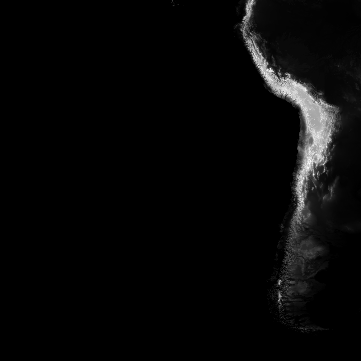

In [22]:
im

## Save a specular map

In [23]:
specMap = np.where(topo2.Z<0,1.0,0.0)

In [26]:
im = toimage(np.flipud(specMap))
im.save('batiLatLonSpec.jpg')
!cp batiLatLonSpec.jpg ../web/img/.

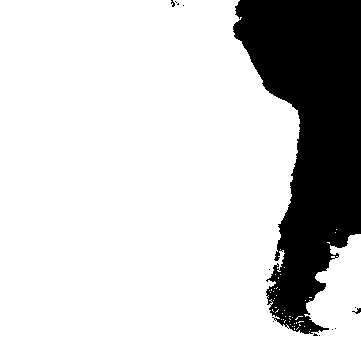

In [27]:
im

## Whole Pacific, Lat-Lon

In [28]:
data = np.load('pacific3min.npy')

In [29]:
r = 3
x = np.unique(data[:,0])
y = np.unique(data[:,1])
z = np.reshape(data[:,2],(y.shape[0],x.shape[0]))[::r,::r]
x = x[::r]
y = y[::r]

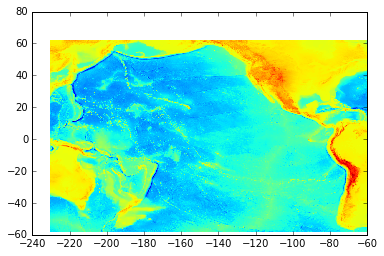

In [30]:
plt.pcolormesh(x,y,z)

In [31]:
zt3,err3,errrel3 = truncate(z)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in log


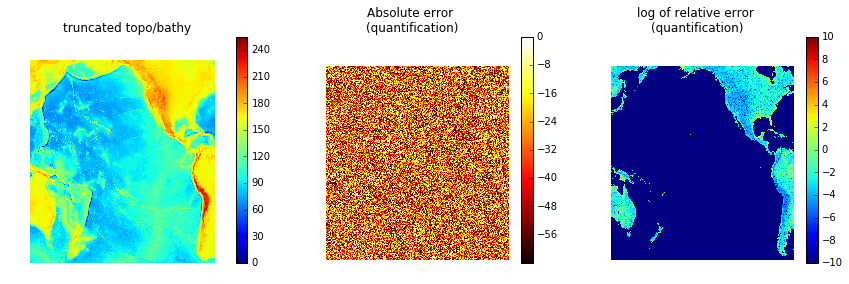

In [32]:
compare(x, y, z, zt3, err3, errrel3)

In [35]:
saveImage(x,y,z, 'batiLatLonPacific')
!cp batiLatLonPacific.jpg ../web/img/.

<PIL.Image.Image image mode=L size=1140x807 at 0x7F87EC81FD10>


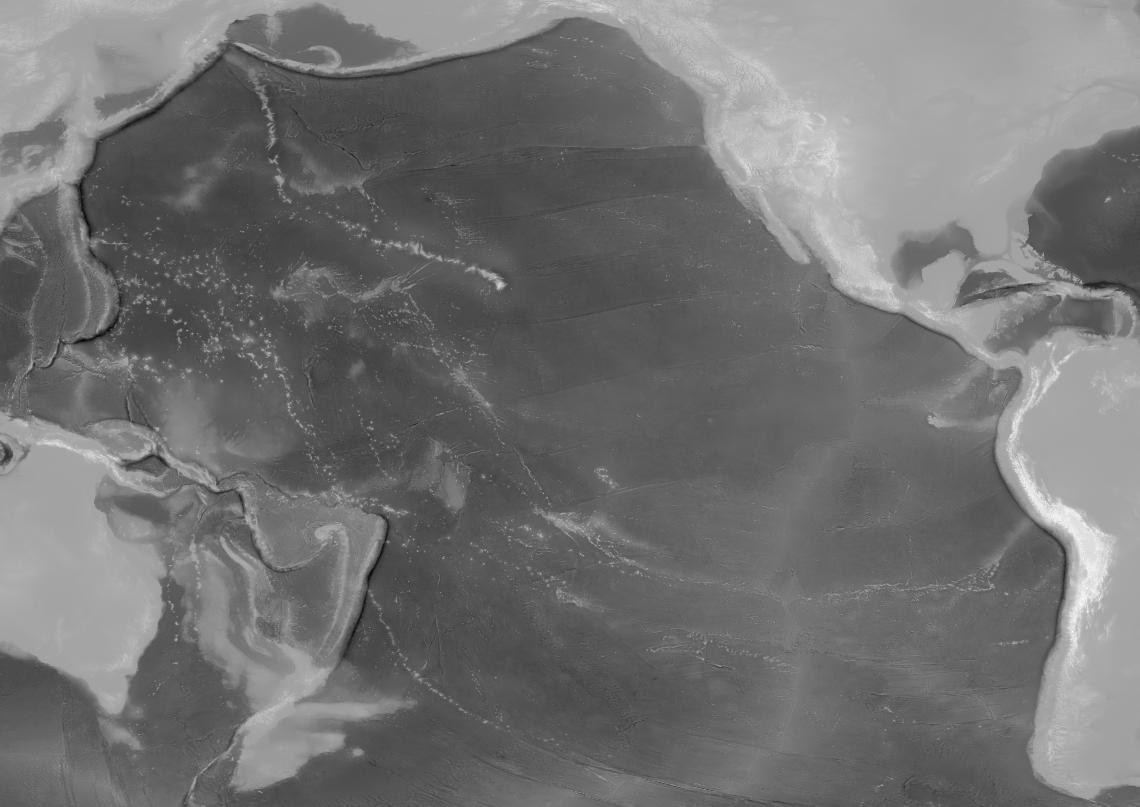

In [36]:
Image('batiLatLonPacific.jpg')

In [38]:
!cat batiLatLonPacific.txt
!cp batiLatLonPacific.txt ../web/img/.

ny   :807
nx   :1140
xmin :-230.000
xmax :-60.099
ymin :-58.000
ymax :61.950
zmin :-10413.283
zmax :5900.932


## Save a map of it

In [39]:
from scipy.misc import toimage
mean_lat = 0.5 * (y.min()+y.max())

topo_extent = (np.min(z), np.max(z))

# Create color map - assume shore is at z = 0.0
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

# sea_cmap = plt.get_cmap('Blues')
sea_cmap = colormaps.make_colormap({ 0.0: [0.0, 0.0, 0.1],
                                     1.0: [0.4,0.4,0.6]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                         data_limits=topo_extent,
                                         data_break=0.0)

In [40]:
Map = z
im = toimage(cmap(norm(np.flipud(Map))))
im.save('batiLatLonPacificMap.jpg')
!cp batiLatLonPacificMap.jpg ../web/img/.

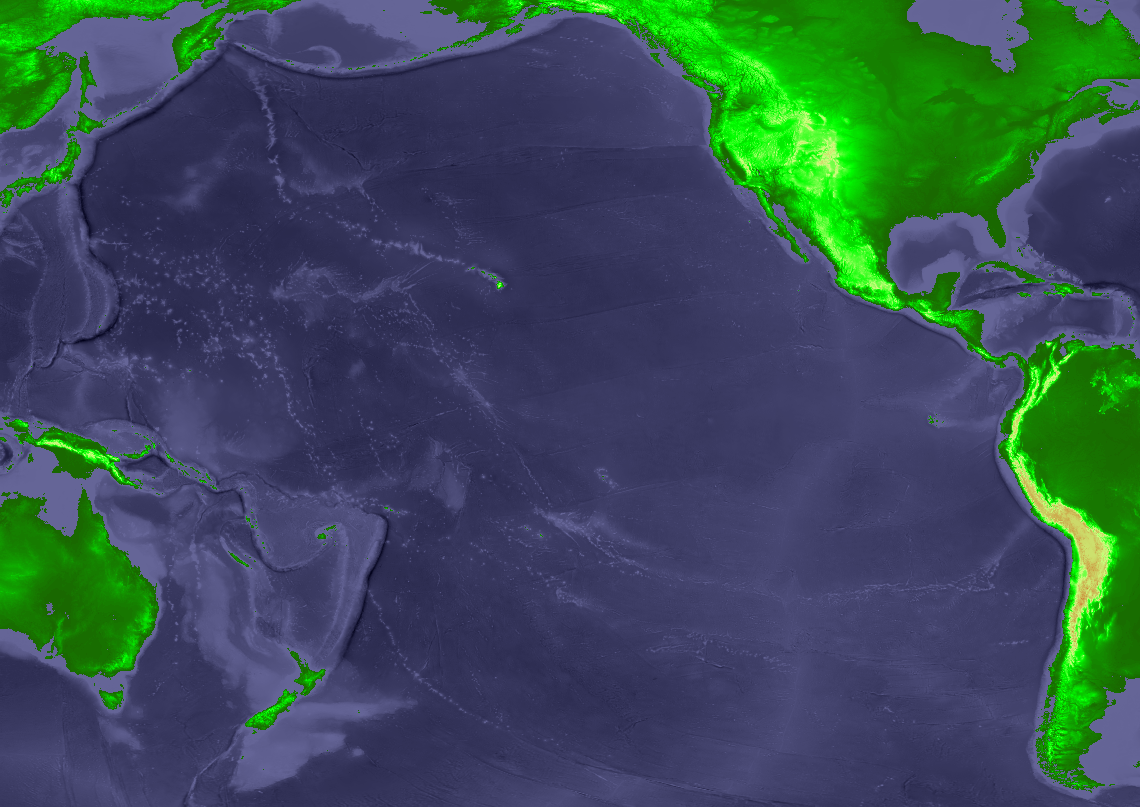

In [41]:
im

## Add a bump map

In [42]:
bumpMap = np.where(z<0,0.0,z)

In [43]:
im = toimage(np.flipud(bumpMap))
im.save('batiLatLonPacificBumpMap.jpg')
!cp batiLatLonPacificBumpMap.jpg ../web/img/.

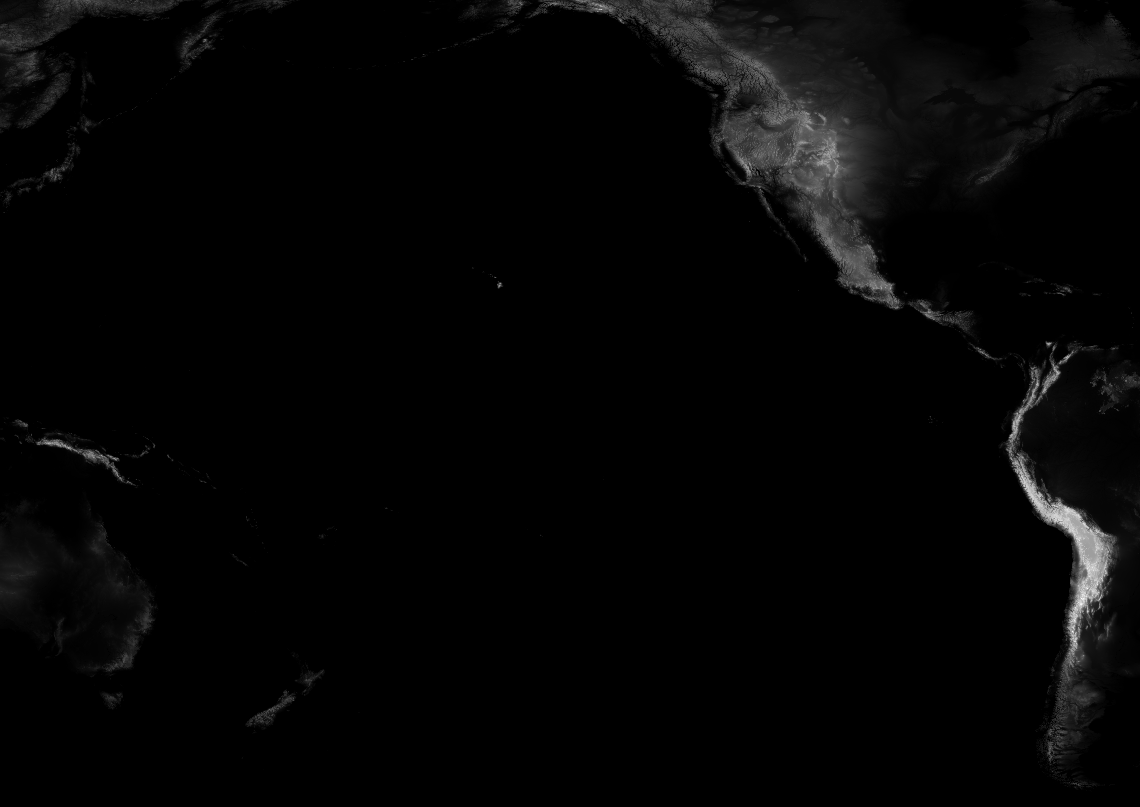

In [44]:
im

### And a specular map

In [45]:
specMap = np.where(z<0,1.0,0.0)

In [46]:
im = toimage(np.flipud(specMap))
im.save('batiLatLonPacificSpecMap.jpg')
!cp batiLatLonPacificSpecMap.jpg ../web/img/.

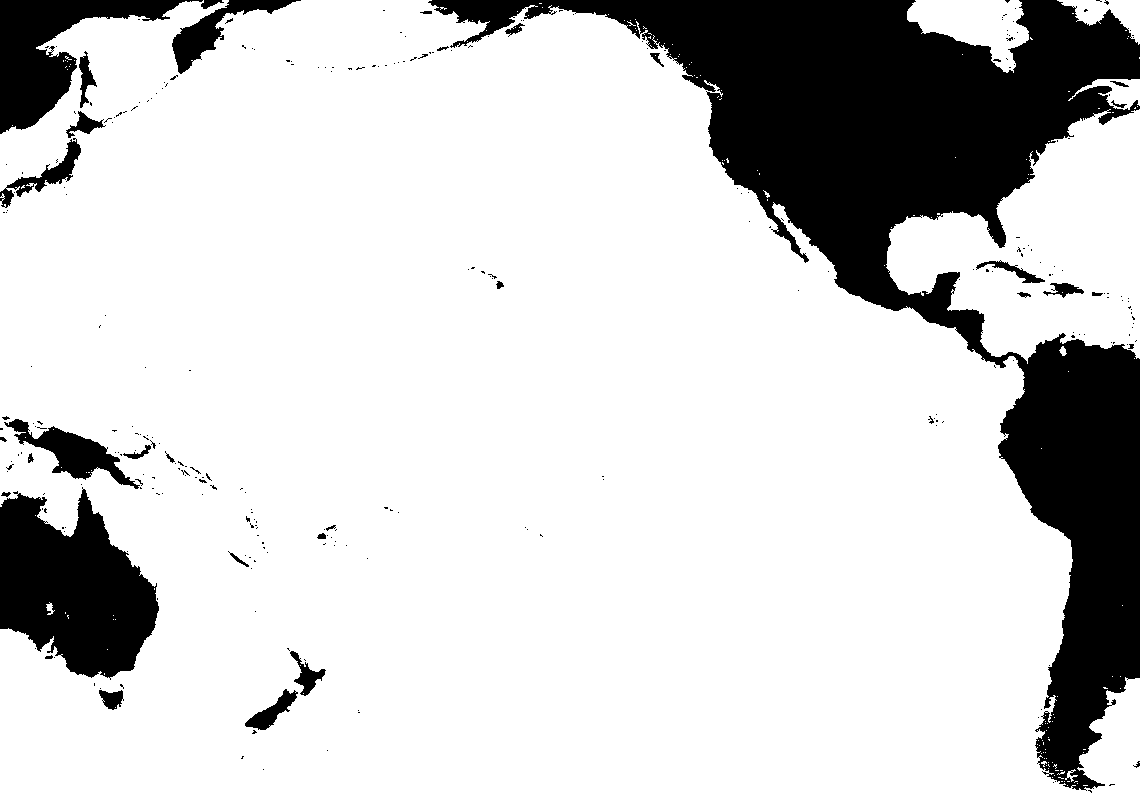

In [47]:
im